In [1]:
import sys
import os
import importlib
#root = './drive/My Drive/Colab Notebooks/rl/'
root = './'
sys.path.insert(1, root + 'env')
sys.path.insert(1, root + 'agents')
sys.path.insert(1, root + 'common')

import gym
import pylab
import random
import sarsa_agent
import aa_gun,jet_table_simple
import numpy as np
from collections import deque
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from agents import autoencoder_rl_wrapper, autoencoder_rl_wrapper2

import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import pickle
import copy
import vizdoom
from vizdoom import *

try:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
except Exception:
    print('GPU error')

In [2]:
#!sudo apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
#nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
#libopenal-dev timidity libwildmidi-dev unzip
#!sudo apt-get install libboost-all-dev
#!pip install vizdoom

In [3]:
#как сделать запись в файл? Перегони в картинку, её перегони в верный формат.

In [4]:
#(224, 224, 3) - размеры resnet101, resnet 101v2

In [5]:
# Creates and initializes ViZDoom environment.
def initialize_vizdoom(config_file_path,doom_map="map01"):
    print("Initializing doom...")
    game = DoomGame()
    game.load_config(config_file_path)
    game.set_doom_map(doom_map)
    game.set_screen_format(ScreenFormat.RGB24)
    game.set_screen_resolution(ScreenResolution.RES_200X150)
    game.set_depth_buffer_enabled(True)
    # Enables depth buffer.
    game.set_depth_buffer_enabled(True)
    # Enables labeling of in game objects labeling.
    game.set_labels_buffer_enabled(True)
    # Enables buffer with top down map of the current episode/level.
    game.set_automap_buffer_enabled(True)
    # Enables information about all objects present in the current episode/level.
    #game.set_objects_info_enabled(True)
    # Enables information about all sectors (map layout).
    #game.set_sectors_info_enabled(True)
    # Sets other rendering options (all of these options except crosshair are enabled (set to True) by default)
    game.set_render_hud(True)
    game.set_render_minimal_hud(False)  # If hud is enabled
    game.set_render_crosshair(False)
    game.set_render_weapon(True)
    game.set_render_decals(False)  # Bullet holes and blood on the walls
    game.set_render_particles(False)
    game.set_render_effects_sprites(False)  # Smoke and blood
    game.set_render_messages(False)  # In-game messages
    game.set_render_corpses(True)
    game.set_render_screen_flashes(True)  # Effect upon taking damage or picking up items
    # Adds buttons that will be allowed.
    lst_acts = [Button.MOVE_LEFT,Button.MOVE_RIGHT,Button.MOVE_FORWARD,Button.MOVE_BACKWARD,Button.TURN_LEFT,Button.TURN_RIGHT,Button.ATTACK,Button.USE]#,Button.SELECT_NEXT_WEAPON]
    for action in lst_acts:
        game.add_available_button(action)
    # Adds game variables that will be included in state.
    game.add_available_game_variable(GameVariable.AMMO2)
    game.add_available_game_variable(GameVariable.HEALTH)
    game.add_available_game_variable(GameVariable.FRAGCOUNT)
    game.add_available_game_variable(GameVariable.KILLCOUNT)
    game.add_available_game_variable(GameVariable.ITEMCOUNT)
    game.add_available_game_variable(GameVariable.HITCOUNT)
    # Causes episodes to finish after 200 tics (actions)
    game.set_episode_timeout(2000)
    # Makes episodes start after 10 tics (~after raising the weapon)
    game.set_episode_start_time(10)
    # Makes the window appear (turned on by default)
    game.set_window_visible(True)
    # Turns on the sound. (turned off by default)
    game.set_sound_enabled(True)
    # Sets the living reward (for each move) to -1
    game.set_living_reward(1)
    # Sets ViZDoom mode (PLAYER, ASYNC_PLAYER, SPECTATOR, ASYNC_SPECTATOR, PLAYER mode is default)
    game.set_mode(Mode.PLAYER)
    # Enables engine output to console.
    #game.set_console_enabled(True)
    # Initialize the game. Further configuration won't take any effect from now on.
    time.sleep(1)
    game.init()
    print("Doom initialized.")
    return game

In [6]:
black_square = np.zeros((224, 224, 3))

In [7]:
EPISODES=3000
doom=1

print('_____',pd.Timestamp.now())
#здесь весь код от инициализации модели до выдачи scores.
# In case of CartPole-v1, maximum length of episode is 500

#env = jet_table_simple.jet_table_simple_env()
#env = gym.make('Seaquest-ramNoFrameskip-v0')
#env = gym.make('BattleZone-ram-v0')
#env = gym.make('Robotank-ram-v0')
#env = gym.make('Pong-ram-v0')
if doom:
    #basic
    #map02 - фаерболы, немного
    #04 - лостсоул
    #06 - мобы с огнестрелом и с фаерболами
    #10 - мобы с огнестрелом и фаерболами, перепад высот, деревья. Дальняя перестрелка
    #11 - мобы с огнестрелом, аптечки
    #26 - мобы с огнестрелом, патроны
    #27 - телепорт,оружие, вероятно, мобы. Всё закрыто
    #doom2
    #1 - 2 зомбаря
    #2 - 3 зомбаря
    #3 - импы, зомби
    #5 - двустволка, мегаздоровье, зомби по бокам на выходе из комнатки
    #6 - зомби, импы, ревенант
    #9 - кислота, целей не вижу, но за что-то дают награды, видимо, враги всё же есть поблизости
    #11 - много зомби, кислота
    #13 - прилично врагов, в том числе импы и арахнотрон
    env = initialize_vizdoom(root + 'doom_files/scenarios/doom2.cfg',doom_map="map05")
    #[Button.MOVE_LEFT,Button.MOVE_RIGHT,Button.MOVE_FORWARD,Button.MOVE_BACKWARD,Button.TURN_LEFT,Button.TURN_RIGHT,Button.ATTACK,Button.USE ]
    actions = [[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]]
#env = gym.make('Breakout-ram-v0')
#env = gym.make('SpaceInvaders-ram-v0')
#env = gym.make('MsPacman-ram-v0')
#env=CartPoleEnv9()
#env = aa_gun.AA_gun_simple0_env()
# get size of state and action from environment
if doom:
    #state_size = env.get_screen_size()
    state_size = (env.get_screen_height(),env.get_screen_width(),3)
else:
    state_size = env.observation_space.shape[0]
if doom:
    action_size = len(actions)
else:
    action_size = env.action_space.n

_____ 2021-01-26 10:05:47.076644
Initializing doom...
Doom initialized.


In [8]:
#np.shape(state) # (150, 200, 3)world model mse

In [9]:
importlib.reload(autoencoder_rl_wrapper)
importlib.reload(autoencoder_rl_wrapper2)
importlib.reload(sarsa_agent)
sarsa = sarsa_agent.SarsaAgent_RND_dreamworlds_actor(state_size=6, action_size=action_size,deque_len=6000)
sarsa.discount_factor = 0.994
sarsa.planning_horison = 900
agent = autoencoder_rl_wrapper.AutoencoderRLWrapper(state_size, action_size, encoder_layers_count=1, 
                                                    path_to_network='autoencoder_video.h5', 
                                                    x_path=['./data/x_movies_0.pkl'],y_path=['./data/y_movies_0.pkl'])
sarsa.parent = agent
wrapper2 = autoencoder_rl_wrapper2.AutoencoderRLWrapper2(state_size=49*26, action_size=action_size)
wrapper2.add_deeper_rl(sarsa)
sarsa.higher_level = wrapper2
agent.add_deeper_rl(wrapper2)
agent.train_start=1100
#agent.epsilon_decay=0.9999
agent.render=True
agent.train_start

scores, episodes = [], []
agent.epsilon = 1
t = 0
action = 2
frames = deque(maxlen=1600)

2/2 - 0s - loss: 2411.6890


In [10]:
#state=5 - на 10м эпизоде всё ещё не обучилась world model
#state=5, sargen делает 1 точку

reward 0.5
reward -0.12
sr_fit
Epoch 1/6
1/1 [==============================] - 0s 1ms/step - loss: 2.8322
Epoch 2/6
1/1 [==============================] - 0s 1ms/step - loss: 2.5754
Epoch 3/6
1/1 [==============================] - 0s 1ms/step - loss: 2.7733
Epoch 4/6
1/1 [==============================] - 0s 2ms/step - loss: 2.6451
Epoch 5/6
1/1 [==============================] - 0s 1ms/step - loss: 2.6386
Epoch 6/6
1/1 [==============================] - 0s 1ms/step - loss: 2.4391
sr_fit
Epoch 1/6
1/1 [==============================] - 0s 2ms/step - loss: 2.2227
Epoch 2/6
1/1 [==============================] - 0s 2ms/step - loss: 2.5759
Epoch 3/6
1/1 [==============================] - 0s 1ms/step - loss: 1.9806
Epoch 4/6
1/1 [==============================] - 0s 1ms/step - loss: 2.1411
Epoch 5/6
1/1 [==============================] - 0s 1ms/step - loss: 2.0153
Epoch 6/6
1/1 [==============================] - 0s 2ms/step - loss: 2.3994
sr_fit
Epoch 1/6
1/1 [============================

1/1 [==============================] - 0s 1ms/step - loss: 1.9430
Epoch 5/6
1/1 [==============================] - 0s 1ms/step - loss: 1.8878
Epoch 6/6
1/1 [==============================] - 0s 1ms/step - loss: 1.7412
sr_fit
Epoch 1/6
1/1 [==============================] - 0s 2ms/step - loss: 1.8422
Epoch 2/6
1/1 [==============================] - 0s 1ms/step - loss: 1.6766
Epoch 3/6
1/1 [==============================] - 0s 1ms/step - loss: 2.0575
Epoch 4/6
1/1 [==============================] - 0s 1ms/step - loss: 1.9626
Epoch 5/6
1/1 [==============================] - 0s 1ms/step - loss: 1.9172
Epoch 6/6
1/1 [==============================] - 0s 1ms/step - loss: 1.7770
sr_fit
Epoch 1/6
1/1 [==============================] - 0s 1ms/step - loss: 1.9044
Epoch 2/6
1/1 [==============================] - 0s 1ms/step - loss: 2.0642
Epoch 3/6
1/1 [==============================] - 0s 1ms/step - loss: 1.9155
Epoch 4/6
1/1 [==============================] - 0s 1ms/step - loss: 1.6980
Epoch 5/

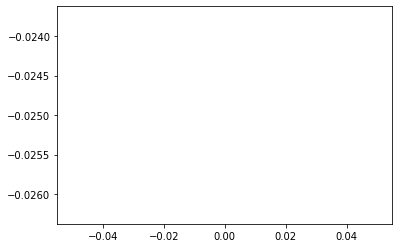

episode: 0   score: -0.024999999999999967 -0.024999999999999967   epsilon: 0.02039694981233469 t: 421 KILLCOUNT 0.0
reward 0.5
r_predict_array_augmented [-0.63309026 -0.19160731 -0.53412482 -0.18630656 -0.40447338  0.11376104
 -0.28253887 -0.45702459]
r_predict_array_augmented [-1.13509622 -0.77957696 -1.21040918 -0.5730369  -0.93236351 -0.51977064
 -0.63657698 -0.90974783]
r_predict_array_augmented [-0.55492369 -1.47065585 -1.24981886 -1.54194153 -0.72971223 -0.85551041
 -0.63832458 -0.18895936]
r_predict_array_augmented [-1.01650462 -1.34297897 -1.69244129 -1.47573487 -1.52149356 -1.16577905
 -1.04014297 -0.67164277]
r_predict_array_augmented [-0.42907891 -1.13575715 -1.16617869 -1.16036077 -1.27576245 -0.90450107
 -1.04926357 -0.66512969]
r_predict_array_augmented [ 0.42209687 -0.11913641  0.01185994 -0.43244116 -0.40138176  0.21353198
  0.37527629  0.64696454]
r_predict_array_augmented [ 0.31661532 -0.15509139  0.03235147 -0.66503292 -0.1238408   0.08321249
  0.0441123   0.53167949

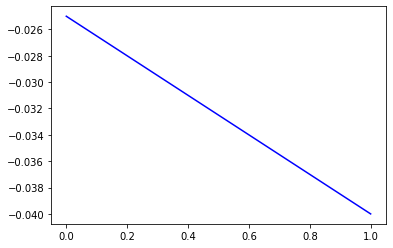

episode: 1   score: -0.039999999999999994 -0.03249999999999998   epsilon: 0.009979391231462048 t: 1285 KILLCOUNT 0.0
reward 0.5
r_predict_array_augmented [-0.42175958 -0.25980316 -0.52452122  0.5857758   0.4730611  -0.39881472
  0.62656206  0.6795675 ]
r_predict_array_augmented [-1.44539841 -1.49886512 -1.44708299 -0.70317661 -0.46342485 -1.24349721
 -1.37017513 -0.41111132]
r_predict_array_augmented [-1.19610479 -1.47632883 -1.62056931 -1.25307028 -0.48290075 -1.22233
 -1.34831144 -0.63942323]
r_predict_array_augmented [-0.05506079 -0.48841223 -0.37642784 -0.14941243 -0.1153552  -0.16311594
  0.10725362 -0.42780754]
r_predict_array_augmented [-0.21259333 -0.55445006 -0.43747622 -0.34389432 -0.19221066 -0.67787757
 -0.11899156 -0.37737143]
r_predict_array_augmented [-0.22525387 -0.56950661 -0.43277897 -0.38291619 -0.21926712 -0.75363846
 -0.19163422 -0.45436229]
r_predict_array_augmented [-0.20493526 -0.16257883 -0.41756976 -0.16055517 -0.1334284  -0.33791517
 -0.4438388  -0.02859358]


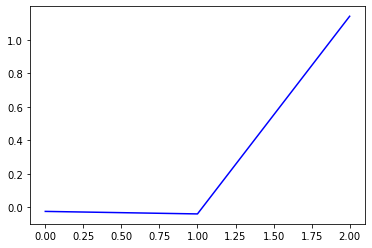

episode: 2   score: 1.14 0.35833333333333334   epsilon: 0.009979391231462048 t: 2952 KILLCOUNT 0.0
reward 0.5
r_predict_array_augmented [-0.0849874  -0.25322958 -0.15550582 -0.17330781 -0.18090135 -0.12853408
 -0.10605829 -0.17386571]
r_predict_array_augmented [-0.08929888 -0.16922748 -0.11004093 -0.21260529 -0.01821283 -0.06659282
 -0.12740994 -0.13255719]
r_predict_array_augmented [-0.05656417 -0.15399158  0.02117397 -0.09707396 -0.11402697 -0.01639371
 -0.13658015 -0.0609555 ]
r_predict_array_augmented [-0.02073778 -0.14964869 -0.02160422 -0.16217564 -0.19930644 -0.10168662
 -0.15100586 -0.08778452]
r_predict_array_augmented [-0.09324988 -0.16841137 -0.14482519 -0.15866248 -0.16922092 -0.18844283
 -0.09826491 -0.18463339]
r_predict_array_augmented [-0.04697352 -0.13084224 -0.1060847  -0.07148666 -0.04839866 -0.09563482
 -0.07351022 -0.12887486]
r_predict_array_augmented [ 0.05369395  0.02991222  0.03742339  0.01493429  0.01760025 -0.00362879
 -0.03211314  0.03972863]
r_predict_array

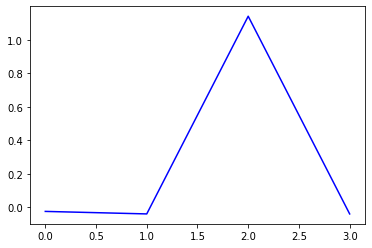

episode: 3   score: -0.03999999999999995 0.25875   epsilon: 0.009979391231462048 t: 3913 KILLCOUNT 0.0
reward 0.5
r_predict_array_augmented [ 0.04440789  0.02046978 -0.00091604 -0.0223141  -0.00307713  0.00282519
  0.0513428   0.00692095]
r_predict_array_augmented [ 0.05399429  0.03270872  0.03410949 -0.00277497  0.03067476  0.02575923
  0.05901009  0.04631557]
CHILDHOOD IS OVER
reward -0.06
r_predict_array_augmented [5.83481278 6.16715433 5.73398557 5.94182872 5.96717218 5.46522931
 6.17213284 5.64872319]
reward -0.105
r_predict_array_augmented [1.03222535 0.97563738 0.76962091 0.79190895 0.79777298 0.61250455
 1.04608958 0.43378485]
r_predict_array_augmented [-0.32600944 -0.06923385 -0.22906059  0.14647843  0.00437004 -0.22654816
 -0.03010179 -0.74975282]
reward -0.135
r_predict_array_augmented [-0.2264391  -0.04878866  0.12894607 -0.02181605 -0.0683427  -0.47082136
  0.0284804  -0.43923307]
reward -0.15
r_predict_array_augmented [ 0.21605341  0.09885475  0.39587097  0.19678444  0.12

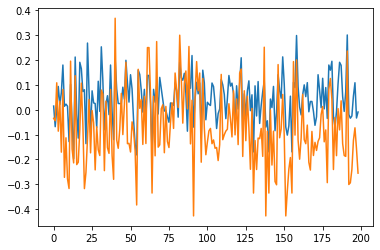

sar_err fact, frc


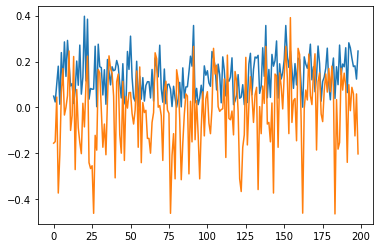

model_sh fact, frc
mean delta =  0.47261757


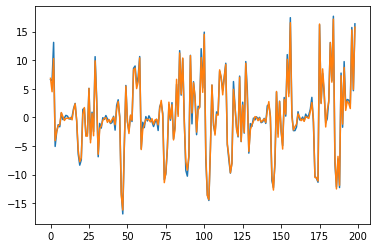

error in prediction hash *self.hash_curiosity


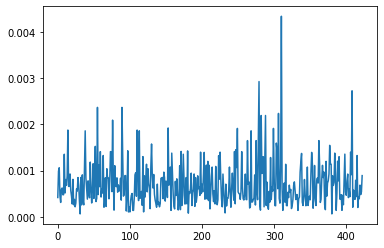

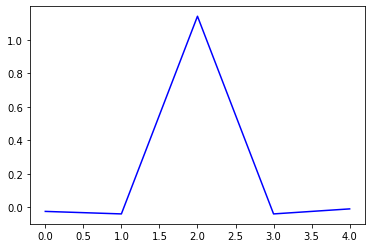

episode: 4   score: -0.009999999999999981 0.205   epsilon: 0.013432974159355952 t: 4420 KILLCOUNT 0.0
reward 0.5
r_predict_array_augmented [-0.03681902 -0.02970249  0.13713946 -0.03718938  0.01016804  0.09846714
  0.10170061  0.01130117]
r_predict_array_augmented [ 0.14601653  0.27815251  0.02678522 -0.16389381  0.00901484  0.08728438
 -0.05123187  0.40105288]
r_predict_array_augmented [ 0.36538055  0.15290492 -0.06468583 -0.39595134  0.17889684  0.0475555
  0.01991645  0.01960471]
r_predict_array_augmented [-0.29472464 -0.15116551 -0.23782392 -0.47416777 -0.04004305  0.06570008
 -0.33237345  0.09773118]
r_predict_array_augmented [-0.320863   -0.65932524 -0.75854836 -1.04878496 -0.58199583 -0.44951982
 -0.75707276 -0.61629844]
r_predict_array_augmented [-1.11500347 -0.87530837 -1.08204627 -0.96035197 -0.89960903 -0.94300433
 -1.03185374 -0.79441041]
r_predict_array_augmented [-1.09340091 -0.85804174 -1.06214621 -0.91894008 -0.85119274 -0.9058106
 -0.98496002 -0.81007535]
r_predict_arra

In [ ]:
for e in range(EPISODES):
    done = False
    score = 0
    if doom:
        env.new_episode()
        state = env.get_state().screen_buffer
    else:
        state = env.reset()
    state = np.reshape(state, [state_size[0], state_size[1], state_size[2]])
    
    kills = 0
    items = 0
    health = 0
    hits = 0
    while not done:
        t += 1
        # get action for the current state and go one step in environment
        act_verbose = np.random.rand()<0.02
        action = agent.get_action(state,act_verbose)
        if doom:
            reward = env.make_action(actions[action])
            reward = env.get_game_variable(GameVariable.KILLCOUNT)-kills#я считаю как хочу
            reward += (env.get_game_variable(GameVariable.ITEMCOUNT)-items)*0.1
            reward += (env.get_game_variable(GameVariable.HITCOUNT)-hits)*0.15
            reward += (env.get_game_variable(GameVariable.HEALTH)-health)*0.005
            kills = env.get_game_variable(GameVariable.KILLCOUNT)
            items = env.get_game_variable(GameVariable.ITEMCOUNT)
            health = env.get_game_variable(GameVariable.HEALTH)
            hits = env.get_game_variable(GameVariable.HITCOUNT)
            if reward!=0:
                print('reward',reward)
            try:
                next_state = env.get_state().screen_buffer
            except Exception:
                print('cannot parse frame')
            frames.append(next_state)
            next_state = np.reshape(next_state, [state_size[0], state_size[1], state_size[2]])
            done = env.is_episode_finished() or env.is_player_dead()
            #if env.is_player_dead():
            #    reward = -100
        else:
            next_state, reward, done, info = env.step(action)
        
        next_state = np.reshape(next_state, [state_size[0], state_size[1], state_size[2]])
        # if an action make the episode end, then gives penalty of -100

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        #if next_state[0,11]!=reward:
        #    print('state[13]!=reward',state[0,11],reward)

        # every time step do the training
        if np.random.rand()<0.05:
            agent.train_model()
        score += reward
        state = next_state
        
        if doom:
            if env.is_player_dead():
                # Use this to respawn immediately after death, new state will be available.
                env.respawn_player()

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()

            # every episode, plot the play time
            scores.append(score)
            episodes.append(e)
            plt.plot(episodes, scores, 'b')
            plt.show()
            #pylab.savefig("./save_graph/aa_gun_dqn.png")

            print("episode:", e, "  score:", score,np.mean(scores), "  epsilon:", sarsa.epsilon, 't:', t, 'KILLCOUNT',env.get_game_variable(GameVariable.KILLCOUNT))

In [ ]:
np.shape(sarsa.s)

In [ ]:
for layer in model.layers:
    print(layer.name,layer.input_shape,layer.output_shape)

In [ ]:
np.shape(sarsa.sar_arr_y)

In [ ]:
sarsa.state_size + sarsa.action_size

In [ ]:
#sarsa.decode_to_print(np.array(sarsa.s[0],ndmin=2))

In [ ]:
#np.array(sarsa.r,ndmin=2).T

In [ ]:
len(sarsa.s)

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
plt.plot(moving_average(scores,15))
plt.show()
plt.plot(scores)

In [ ]:
#agent.deeper_rl.deeper_rl.model_sargen.layers[0].input_shape
#agent.deeper_rl.model_sargen.layers[5].output_shape

In [ ]:
sarsa.train_model(draw=True,epochs=50,diaposon=[-800,-1])

In [ ]:
plt.plot(sarsa.r)
plt.show()
plt.plot(sarsa.done)
plt.show()
plt.plot(sarsa.r_disco)
plt.show()
plt.plot(sarsa.r_disco_curiosity)

In [ ]:
import imageio
#imageio.mimsave('output_video.gif', [frames[i] for i in range(1200,2400)])
imageio.mimsave('output_video.gif', frames)

In [ ]:
#len(frames)